In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from projectnb import ProjectContext, ProjectUtil
pc = ProjectContext.ProjectContext(sc, 'ccba385a-e5f0-49a7-bcea-813152f16f4b', 'p-b7bd783c66b6f7fc4cfc2937c260e96a9a804a80')

<h1 id="tocheading">Demo No Pago Créditos</h1>
<div id="toc"></div>

<img src="https://github.com/elenalowery/DSX_Local_Workshop/blob/master/img/CC_Intro.JPG?raw=true" width="800" height="500" align="middle"/>

Un banco aprobó a clientes de bajo perfil créditos sin mucho escrutinio. Algunos de ellos no honraron sus obligaciones. El banco piensa que pudieron haber analizado de mejor manera la información para seleccionar adecuadamente a los aplicantes de préstamos. IBM sugiere habilitar decisiones basadas en analítica para resolver el problema.

Vamos a demostrar

1. Acceso desde DSX a información de una tabla alojada en IBM Integrated Analytics System.
2. Uso de las librerías scikit-learn y Mlib para modelamiento predictive dentro de DSX.
3. Ejecución del Modelo para predicción sobre el conjunto de datos de pruebas.


In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Carga de Librerías

Run the following cell to import required libraries.

In [3]:
import sklearn
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import pandas as pd
pd.options.display.max_columns = 999

import brunel

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency,ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score

import numpy as np

import urllib3, requests, json

## Carga de Información Histórica

In [4]:
# Access 'CUST_HISTORY_DEMO' data conn from the project.
cust_spark = ProjectUtil.load_dataframe_from_connector(pc, "CUST_HISTORY_DEMO")
cust_spark.show()


+--------+-----------------+-----------------------+--------------------+--------------+------------+-----------------+-----------+-----+--------+----------+------------------+------------+---------+----------------+---------------+---------+-----------------+------------------+----+-------------+--------------+---------+--------+---------+------------------+----------+
|MERCHANT|ACCT_STATUS_K_USD|CONTRACT_DURATION_MONTH|             HISTORY|CREDIT_PROGRAM|AMOUNT_K_USD|     ACCOUNT_TYPE|   ACCT_AGE|STATE|IS_URBAN|IS_XBORDER|SELF_REPORTED_ASMT|CO_APPLICANT|GUARANTOR|PRESENT_RESIDENT|OWN_REAL_ESTATE|PROP_UNKN|ESTABLISHED_MONTH|OTHER_INSTALL_PLAN|RENT|OWN_RESIDENCE|NUMBER_CREDITS|RFM_SCORE|BRANCHES|TELEPHONE|SHIP_INTERNATIONAL|IS_DEFAULT|
+--------+-----------------+-----------------------+--------------------+--------------+------------+-----------------+-----------+-----+--------+----------+------------------+------------+---------+----------------+---------------+---------+------------

Creamos un DataFrame Pandas desde el DataFrame de Spark. Un DataFrame de Pandas es requerido para el siguiente análisis.

In [5]:
cust_pd=cust_spark.toPandas()
cust_pd.head()

,MERCHANT,ACCT_STATUS_K_USD,CONTRACT_DURATION_MONTH,HISTORY,CREDIT_PROGRAM,AMOUNT_K_USD,ACCOUNT_TYPE,ACCT_AGE,STATE,IS_URBAN,IS_XBORDER,SELF_REPORTED_ASMT,CO_APPLICANT,GUARANTOR,PRESENT_RESIDENT,OWN_REAL_ESTATE,PROP_UNKN,ESTABLISHED_MONTH,OTHER_INSTALL_PLAN,RENT,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,BRANCHES,TELEPHONE,SHIP_INTERNATIONAL,IS_DEFAULT
0,933,NONE,9,CRITICAL ACCOUNT,NEW CAR,1224,up to 100 K USD,1 to 4 YRS,CT,NO,YES,NO,NO,NO,1 to 2 YRS,YES,NO,30,NO,NO,YES,2,3,1,NO,NO,No
1,952,0 USD,36,DELAY IN PAST,RETRAINING,2145,up to 100 K USD,4 to 7 YRS,NJ,NO,YES,NO,NO,NO,1 to 2 YRS,NO,NO,24,NO,NO,YES,2,3,1,YES,NO,Yes
2,967,0 to 200 USD,27,CRITICAL ACCOUNT,ELECTRONICS,2520,500 to 1000 K USD,1 to 4 YRS,NY,NO,YES,NO,NO,NO,2 to 3 YRS,NO,NO,23,NO,NO,YES,2,2,1,NO,NO,Yes
3,3,NONE,12,CRITICAL ACCOUNT,EDUCATION,2096,up to 100 K USD,4 to 7 YRS,NJ,NO,YES,NO,NO,NO,above 4 YRS,YES,NO,49,NO,NO,YES,1,2,2,NO,NO,No
4,27,NONE,6,NONE TAKEN,ELECTRONICS,426,up to 100 K USD,above 7 YRS,NY,NO,NO,YES,NO,NO,4,NO,NO,39,NO,NO,YES,1,2,1,NO,NO,No


### Vista General del Conjunto de Datos

Hagamos una revisión rápida del Conjunto de Datos.

In [6]:
print "Hay " + str(len(cust_pd)) + " observaciones en el conjunto de datos histórico de clientes."
print "Hay " + str(len(cust_pd.columns)) + " variables en el conjunto de datos."

print "\n******************Estadísticas Descriptivas*****************************\n"
print cust_pd.describe()

print "\n******************Vista Rápida del Conjunto de Datos*****************************\n"
cust_pd.head()

Hay 1000 observaciones en el conjunto de datos histórico de clientes.
Hay 27 variables en el conjunto de datos.

******************Estadísticas Descriptivas*****************************

          MERCHANT  CONTRACT_DURATION_MONTH  AMOUNT_K_USD  ESTABLISHED_MONTH  \
count  1000.000000              1000.000000   1000.000000        1000.000000   
mean    500.500000                20.903000   3271.258000          35.546000   
std     288.819436                12.058814   2822.736876          11.375469   
min       1.000000                 4.000000    250.000000          19.000000   
25%     250.750000                12.000000   1365.500000          27.000000   
50%     500.500000                18.000000   2319.500000          33.000000   
75%     750.250000                24.000000   3972.250000          42.000000   
max    1000.000000                72.000000  18424.000000          75.000000   

       NUMBER_CREDITS    RFM_SCORE     BRANCHES  
count     1000.000000  1000.000000  1000.0

,MERCHANT,ACCT_STATUS_K_USD,CONTRACT_DURATION_MONTH,HISTORY,CREDIT_PROGRAM,AMOUNT_K_USD,ACCOUNT_TYPE,ACCT_AGE,STATE,IS_URBAN,IS_XBORDER,SELF_REPORTED_ASMT,CO_APPLICANT,GUARANTOR,PRESENT_RESIDENT,OWN_REAL_ESTATE,PROP_UNKN,ESTABLISHED_MONTH,OTHER_INSTALL_PLAN,RENT,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,BRANCHES,TELEPHONE,SHIP_INTERNATIONAL,IS_DEFAULT
0,933,NONE,9,CRITICAL ACCOUNT,NEW CAR,1224,up to 100 K USD,1 to 4 YRS,CT,NO,YES,NO,NO,NO,1 to 2 YRS,YES,NO,30,NO,NO,YES,2,3,1,NO,NO,No
1,952,0 USD,36,DELAY IN PAST,RETRAINING,2145,up to 100 K USD,4 to 7 YRS,NJ,NO,YES,NO,NO,NO,1 to 2 YRS,NO,NO,24,NO,NO,YES,2,3,1,YES,NO,Yes
2,967,0 to 200 USD,27,CRITICAL ACCOUNT,ELECTRONICS,2520,500 to 1000 K USD,1 to 4 YRS,NY,NO,YES,NO,NO,NO,2 to 3 YRS,NO,NO,23,NO,NO,YES,2,2,1,NO,NO,Yes
3,3,NONE,12,CRITICAL ACCOUNT,EDUCATION,2096,up to 100 K USD,4 to 7 YRS,NJ,NO,YES,NO,NO,NO,above 4 YRS,YES,NO,49,NO,NO,YES,1,2,2,NO,NO,No
4,27,NONE,6,NONE TAKEN,ELECTRONICS,426,up to 100 K USD,above 7 YRS,NY,NO,NO,YES,NO,NO,4,NO,NO,39,NO,NO,YES,1,2,1,NO,NO,No


## Análisis Exploratorio de Datos

En esta sección vamos a explorar el conjunto de datos con algunas visualizaciones.

Dos librerías open source son usadas:
* <a href="https://github.com/Brunel-Visualization/Brunel">Brunel</a> Es un lenguaje a alto nivel que describe visualizaciones en términos de acciones compuestas. Utiliza un motor de visualización llamado D3 que dibuja los gráficos y maneja la interacción. Brunel hace más fácil y divertido construir visualizaciones en notebooks de Jupyter.

* <a href="https://seaborn.pydata.org/">Seaborn</a> es una librería de visualización en Python basada en matplotlib. Ofrece una interfaz de alto nivel para dibujar gráficos estadísticos atractivos.

### Variable Objetivo: No Pago de Préstamo

In [7]:
%brunel data('cust_pd') x(IS_DEFAULT) y(#count) color(IS_DEFAULT) bar tooltip(#all) title("Créditos Pagados y No Pagados") axes(x:'Pagados',y:'Número de Créditos')

<IPython.core.display.Javascript object>

Del gráfico de barras se deduce que 300 de of 1000 créditos no fueron pagados.

### No Pago por Destino del Crédito

In [8]:
%brunel data('cust_pd') polar stack bar y(#count) color(CREDIT_PROGRAM) percent(#count) tooltip(#all) | stack bar x(CREDIT_PROGRAM) y(#count) color(IS_DEFAULT) bin(CREDIT_PROGRAM) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

* Los destinos Top 3 de crédito con más clientes son Electronics(28%), New Car(23.4%) y Furniture(18.1%).
* Los destinos Top 3 de crédito con más alta tasa de No Pago son Education(44%), New Car(38%), y Retraining(35.1%)

### No pago de Créditos fuera de la Frontera del Estado

In [9]:
%brunel data('cust_pd') polar stack bar y(#count) color(IS_XBORDER) percent(#count) tooltip(#all) | stack bar x(IS_XBORDER) y(#count) color(IS_DEFAULT) bin(IS_XBORDER) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

La mayoría de clientes tiene transacciones fuera de la frontera. Relativamente tienen una menor tasa de incumplimiento que aquellos que no tienen créditos fuera de la frontera.

### CLIENTES QUE ARRIENDAN SU VIVIENDA VS SU INCUMPLIMIENTO

In [10]:
%brunel data('cust_pd') stack bar x(RENT) y(#count) color(IS_DEFAULT: blue-red) bin(RENT) sort(RENT) percent(#count) label(#count) tooltip(#all)

<IPython.core.display.Javascript object>

Observamos que los clientes que arriendan su vivienda tienen una tasa de incumplimiento más alta.

### TASA DE INCLUMPLIMIENTO vs HISTORIAL DEL CLIENTE

In [11]:
%brunel data('cust_pd') bar x(HISTORY) y(#count) color(HISTORY) tooltip(#all) | stack bar x(HISTORY) y(#count) color(IS_DEFAULT: green-red) bin(HISTORY) sort(HISTORY) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

### MONTO DEL CRÉDITO EN DÓLARES VS INCUMPLIMIENTO

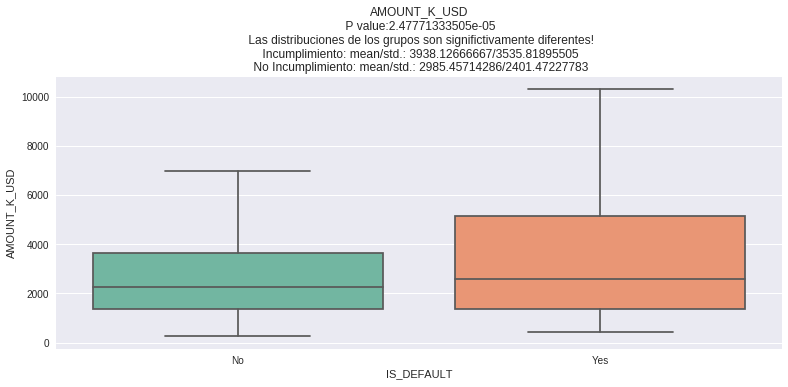

In [12]:
sub_yes = cust_pd[cust_pd["IS_DEFAULT"] == "Yes"]
sub_no = cust_pd[cust_pd["IS_DEFAULT"] == "No"]
    
p_value = ttest_ind(sub_yes['AMOUNT_K_USD'], sub_no["AMOUNT_K_USD"], equal_var = False)[1]

fig, axs = plt.subplots(nrows= 1, figsize=(13, 5))
sns.boxplot(x = "IS_DEFAULT", y = "AMOUNT_K_USD", data = cust_pd, showfliers=False, palette="Set2")
if p_value < .05:
    plt.title("AMOUNT_K_USD" + "\n P value:" + str(p_value) + "\n Las distribuciones de los grupos son significtivamente diferentes!" + "\n Incumplimiento: mean/std.: " + str(sub_yes["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_yes["AMOUNT_K_USD"].describe()[2]) + "\n No Incumplimiento: mean/std.: " + str(sub_no["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_no["AMOUNT_K_USD"].describe()[2]))
else:
    plt.title("AMOUNT_K_USD" + "\n P value:" + str(p_value) + "\n Incumplimiento: mean/std.: " + str(sub_yes["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_yes["AMOUNT_K_USD"].describe()[2]) + "\n No Incumplimiento: mean/std.: " + str(sub_safe["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_no["AMOUNT_K_USD"].describe()[2]))           

En este gráfico de caja, la visualización se ha mejorado con una prueba T. El resultado es significativo, lo que indica que el monto promedio del crédito para el grupo incumplido y el grupo no incumplido son diferentes. El grupo con incumplimiento tienen un monto promedio más grande de crédito.



### No pago por Estado

In [13]:
default_rate = pd.crosstab(cust_pd.IS_DEFAULT, cust_pd.STATE).apply(lambda r: r/r.sum(), axis=0)

default_rate2 = default_rate.T

%brunel data('default_rate2') map color(Yes) key(STATE) label(STATE)


<IPython.core.display.Javascript object>

Brunel también provee una manera ordenada para la visualización. Para este caso de uso los clientes pertenecen a 4 estados: NY, NJ, PA and CT.

### Matriz de Correlación

Un mapa de calor es utilizado para visualizar las correlaciones entre todas las variables contínuas.

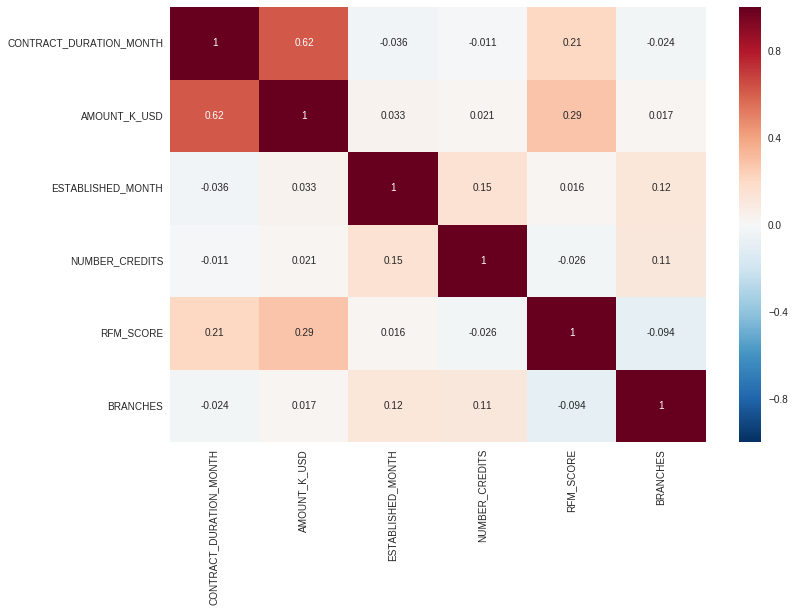

In [14]:
plt.figure(figsize=(12, 8))

corr_df = cust_pd.iloc[:,1:].corr()

sns.heatmap(corr_df, 
            xticklabels = corr_df.columns.values,
            yticklabels = corr_df.columns.values,
            annot = True);


* No hay una correlación fuerte entre la mayoría de variables (características).
* La correlación entre el monto del crédito y la duración del contrato en meses es moderada.

## Modelamiento y Evaluación

Para esta demo, vamos a utilizar RandomForestClassifier() de la librería sklearn para ejecutar un ranking de importancia de características, y Regresión Logística de la librería de Machine Learning de Spark (MLlib) para el modelamiento.

### Bosque Aleatorio Sklearn: Encontrar la Importancia de las Características

In [15]:
# convert IS_DEFAULT to 1/0 (No = 0, Yes= 1)
le = LabelEncoder()

cust_pd_sk = cust_pd
cust_pd_sk.loc[:,'IS_DEFAULT']= le.fit_transform(cust_pd_sk.loc[:,'IS_DEFAULT'])

y = np.float32(cust_pd_sk.IS_DEFAULT)

X = cust_pd.copy()

# drop y 
X = cust_pd_sk.drop(['IS_DEFAULT', 'MERCHANT'], axis = 1)

# Prepocess the data: Encode categorical variables into numeric representations

categoricalColumns = ["ACCT_STATUS_K_USD", "BRANCHES",'HISTORY', 'CREDIT_PROGRAM', 'ACCOUNT_TYPE', 'ACCT_AGE', 'STATE', 'IS_URBAN', 'IS_XBORDER','SELF_REPORTED_ASMT', 'CO_APPLICANT', 'GUARANTOR','PRESENT_RESIDENT', 'OWN_REAL_ESTATE', 'PROP_UNKN','OTHER_INSTALL_PLAN', 'RENT', 'OWN_RESIDENCE','TELEPHONE', 'SHIP_INTERNATIONAL']

for col in categoricalColumns:
    X[col] = le.fit_transform(X[col])

# scale X
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

# split the data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


random_forest = RandomForestClassifier()

#Stratify split and train on 5 folds
skf = StratifiedKFold(y_train, n_folds=5)
counter = 1
for train_fold, test_fold in skf:
    random_forest.fit(X_train[train_fold], y_train[train_fold])
    
    print( str(counter) + ": ", random_forest.score(X_train[test_fold], y_train[test_fold]))
    counter += 1 

cust_pd_sk.head()
    
#### local notes: one interesting error here, if you don't do the import correctly, it will show error Params must be either a param map or a list/tuple of param maps, but got <class 'pandas.core.series.Series'>.

('1: ', 0.77857142857142858)
('2: ', 0.6785714285714286)
('3: ', 0.76428571428571423)
('4: ', 0.72857142857142854)
('5: ', 0.69285714285714284)


,MERCHANT,ACCT_STATUS_K_USD,CONTRACT_DURATION_MONTH,HISTORY,CREDIT_PROGRAM,AMOUNT_K_USD,ACCOUNT_TYPE,ACCT_AGE,STATE,IS_URBAN,IS_XBORDER,SELF_REPORTED_ASMT,CO_APPLICANT,GUARANTOR,PRESENT_RESIDENT,OWN_REAL_ESTATE,PROP_UNKN,ESTABLISHED_MONTH,OTHER_INSTALL_PLAN,RENT,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,BRANCHES,TELEPHONE,SHIP_INTERNATIONAL,IS_DEFAULT
0,933,NONE,9,CRITICAL ACCOUNT,NEW CAR,1224,up to 100 K USD,1 to 4 YRS,CT,NO,YES,NO,NO,NO,1 to 2 YRS,YES,NO,30,NO,NO,YES,2,3,1,NO,NO,0
1,952,0 USD,36,DELAY IN PAST,RETRAINING,2145,up to 100 K USD,4 to 7 YRS,NJ,NO,YES,NO,NO,NO,1 to 2 YRS,NO,NO,24,NO,NO,YES,2,3,1,YES,NO,1
2,967,0 to 200 USD,27,CRITICAL ACCOUNT,ELECTRONICS,2520,500 to 1000 K USD,1 to 4 YRS,NY,NO,YES,NO,NO,NO,2 to 3 YRS,NO,NO,23,NO,NO,YES,2,2,1,NO,NO,1
3,3,NONE,12,CRITICAL ACCOUNT,EDUCATION,2096,up to 100 K USD,4 to 7 YRS,NJ,NO,YES,NO,NO,NO,above 4 YRS,YES,NO,49,NO,NO,YES,1,2,2,NO,NO,0
4,27,NONE,6,NONE TAKEN,ELECTRONICS,426,up to 100 K USD,above 7 YRS,NY,NO,NO,YES,NO,NO,4,NO,NO,39,NO,NO,YES,1,2,1,NO,NO,0


Del resultado de una validación cruzada de 5 pliegues, la precisión promedio varía. El modelo no es muy estable, una razón posible es que nuestro conjunto de datos es realmente pequeño. Necesitaremos restringir la complejidad del modelo, por tal motivo seleccionaremos el top 10 de características importantes para análisis posterior.

In [16]:
features_order = cust_pd_sk.drop(['IS_DEFAULT', 'MERCHANT'], axis = 1).columns.tolist()

feature_importance_dict = {key: val for key, val in zip(features_order, random_forest.feature_importances_)}

for k in sorted(feature_importance_dict, key=feature_importance_dict.get, reverse=True):
    print k, feature_importance_dict[k]

AMOUNT_K_USD 0.150634730026
ACCT_STATUS_K_USD 0.116722933044
ESTABLISHED_MONTH 0.102890446701
CONTRACT_DURATION_MONTH 0.0926785031241
CREDIT_PROGRAM 0.0733523511213
ACCT_AGE 0.0628796870147
HISTORY 0.0476643921656
PRESENT_RESIDENT 0.0388383617939
ACCOUNT_TYPE 0.0378174330203
RFM_SCORE 0.0339273429908
STATE 0.0337471306208
NUMBER_CREDITS 0.0300207394526
OWN_RESIDENCE 0.0290809693904
OWN_REAL_ESTATE 0.0232547653274
OTHER_INSTALL_PLAN 0.0186001854851
TELEPHONE 0.0183310853163
IS_XBORDER 0.0159909135323
PROP_UNKN 0.0145777038777
RENT 0.0130693318637
GUARANTOR 0.0113693571728
BRANCHES 0.0108638823784
SELF_REPORTED_ASMT 0.00880494520568
IS_URBAN 0.00867314021647
CO_APPLICANT 0.00488091925009
SHIP_INTERNATIONAL 0.00132874990861


### Predicción: Regresión Logística usando Spark MLlib

En esta sección, Vamos a usar una Regresión Logística con Spark MLlib para predecir el No Pago de un crédito.<br/>
Utilizaremos un DataFrame de Spark para construír el modelo de Machine Learning de Spark.

In [17]:
cust_spark.printSchema()

root
 |-- MERCHANT: long (nullable = true)
 |-- ACCT_STATUS_K_USD: string (nullable = true)
 |-- CONTRACT_DURATION_MONTH: long (nullable = true)
 |-- HISTORY: string (nullable = true)
 |-- CREDIT_PROGRAM: string (nullable = true)
 |-- AMOUNT_K_USD: long (nullable = true)
 |-- ACCOUNT_TYPE: string (nullable = true)
 |-- ACCT_AGE: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- IS_URBAN: string (nullable = true)
 |-- IS_XBORDER: string (nullable = true)
 |-- SELF_REPORTED_ASMT: string (nullable = true)
 |-- CO_APPLICANT: string (nullable = true)
 |-- GUARANTOR: string (nullable = true)
 |-- PRESENT_RESIDENT: string (nullable = true)
 |-- OWN_REAL_ESTATE: string (nullable = true)
 |-- PROP_UNKN: string (nullable = true)
 |-- ESTABLISHED_MONTH: long (nullable = true)
 |-- OTHER_INSTALL_PLAN: string (nullable = true)
 |-- RENT: string (nullable = true)
 |-- OWN_RESIDENCE: string (nullable = true)
 |-- NUMBER_CREDITS: long (nullable = true)
 |-- RFM_SCORE: long (nullable =

**Preprocesamiento de la información**

In [18]:
# agrupamos las características top 10 en categóricas y numéricas
allCols = cust_pd_sk.drop(['MERCHANT','IS_DEFAULT'], 1).columns.tolist()
importantCols = ['AMOUNT_K_USD', 'ACCT_STATUS_K_USD', 'CONTRACT_DURATION_MONTH', 'ESTABLISHED_MONTH', 'HISTORY', 'CREDIT_PROGRAM', 'ACCT_AGE', 'ACCOUNT_TYPE', "PRESENT_RESIDENT", "STATE"]
importantCols_num = ['AMOUNT_K_USD', 'CONTRACT_DURATION_MONTH', 'ESTABLISHED_MONTH']
importantCols_cat = np.setdiff1d(importantCols, importantCols_num).tolist()

In [19]:
# crear la columna label_str
cust_spark = cust_spark.withColumnRenamed("IS_DEFAULT", 'label_str')

In [20]:
# Transformamos todas las características categóricas a numéricas utilizando One-hot encoder
for categoricalCol in importantCols_cat:
    cust_spark = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index").fit(cust_spark).transform(cust_spark)
    cust_spark = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"classVec").transform(cust_spark)  

In [21]:
# Creamos un vector de características
assemblerInputs = map(lambda c: c + "classVec", importantCols_cat) + importantCols_num
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
cust_spark = assembler.transform(cust_spark)

In [22]:
# Transformamos la columna the label_str a un valor numérico
cust_spark = StringIndexer(inputCol='label_str', outputCol='label').fit(cust_spark).transform(cust_spark)

In [23]:
# mantenemos variables útiles
selectedcols = ["label", "features"]
cust_model = cust_spark.select(selectedcols)

** Partimos los datos en conjuntos de entrenamiento y prueba **

In [24]:
trainingData, testData = cust_model.randomSplit([0.7, 0.3], seed = 824)
print trainingData.count()
print testData.count()

707
293


**Entrenamos el Modelo de Regresión Logística**

In [25]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

** Utilizamos una búsqueda de Validación Cruzada para encontrar los mejores parámetros para el modelo usando CrossValidator y ParamGridBuilder **

In [26]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [1.0,0.3,0.1, 0.03,0.01,0.0]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(trainingData)

** Utilizamos un BinaryClassificationEvaluator para evaluar el modelo**

Note que la mñetrica por defecto del Evaluador de Clasificación Binaria es *areaUnderROC*

Una guía aproximada para clasificar la precisión de una prueba es:

    .90-1 = excellent (A)
    .80-.90 = good (B)
    .70-.80 = fair (C)
    .60-.70 = poor (D)
    .50-.60 = fail (F)

Entonces el rendimiento del modelo está bien.

In [27]:
evaluator.evaluate(cvModel.transform(testData))

0.734563681932103

** Modelo Final**

Avanzaremos con el modelo utilizando el Top 10 de características.

**Hiper-parámetros usados en el modelo final**

In [28]:
print cvModel.bestModel._java_obj.getRegParam()
print cvModel.bestModel._java_obj.getMaxIter()
print cvModel.bestModel._java_obj.getElasticNetParam()
print cvModel.bestModel._java_obj.getThreshold()

0.03
10
0.5
0.5


** Intersección y Pesos del mejor modelo **

In [29]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [30]:
print "Intercepción del Modelo = " + str(cvModel.bestModel.intercept)

coefficients = cvModel.bestModel.coefficients
coefficients = map(lambda w: (float(w),), coefficients)
weightsDF = sqlContext.createDataFrame(coefficients, ["Peso de Cada Característica en el Mejor Modelo"])
weightsDF.show()

Model Intercept = -0.868522279218
+--------------------+
|      Feature Weight|
+--------------------+
| 0.09615462268269712|
|-0.11352112825447482|
|0.053565903989450075|
| -0.2941400675784271|
|                 0.0|
|                 0.0|
| -0.3755837200169409|
| 0.03834058518611631|
| -0.9852342832251154|
| 0.49566506243563885|
|                -0.0|
|-0.22637462732140004|
|   0.396119434486303|
|-0.02300263596259519|
| -0.7408629365037355|
|                 0.0|
|                 0.0|
|                 0.0|
| -0.5769982006030717|
|                 0.0|
+--------------------+
only showing top 20 rows



## Crear Tubería para Machine Learning

In [58]:
trainingData3, testData3 = cust_spark.randomSplit([0.7, 0.3], seed = 824)

SI0 = StringIndexer(inputCol='label_str', outputCol="label1")

lr_final = LogisticRegression(maxIter=10, regParam=0.1, elasticNetParam=0.0, threshold = 0.5, labelCol="label1", featuresCol="features")

assembler_features = VectorAssembler(inputCols=['ACCOUNT_TYPEclassVec','ACCT_AGEclassVec','ACCT_STATUS_K_USDclassVec','CREDIT_PROGRAMclassVec','HISTORYclassVec','PRESENT_RESIDENTclassVec', 'STATEclassVec','AMOUNT_K_USD','CONTRACT_DURATION_MONTH','ESTABLISHED_MONTH'])

pipeline_lr = Pipeline(stages=[SI0, assembler_features, lr_final])
modelo=pipeline_lr.fit(trainingData3)


respuesta=modelo.transform(testData3)

#respuesta.show()

respuestaPandas=respuesta.toPandas()
respuestaPandas.head()

testData3=testData3.toPandas()
testData3.head()

#print(respuestaPandas.shape)

indice=0;
while indice<respuestaPandas.shape[0]:
    if (respuestaPandas.iloc[indice,47]==testData3.iloc[indice,42]):
        print ("Elemento: {:2d} ------>predicción: {:f} real: {:f}, probabilidad: {:s}".format(indice,respuestaPandas.iloc[indice,47],testData3.iloc[indice,42],respuestaPandas.iloc[indice,46]))
    indice +=1
#print(respuestaPandas['prediction'])

#for elemento in respuestaPandas:
#    print(elemento)





Elemento:  0 ------>predicción: 0.000000 real: 0.000000, probabilidad: [0.932004562314,0.0679954376864]
Elemento:  1 ------>predicción: 0.000000 real: 0.000000, probabilidad: [0.502463011644,0.497536988356]
Elemento:  3 ------>predicción: 0.000000 real: 0.000000, probabilidad: [0.886991731381,0.113008268619]
Elemento:  4 ------>predicción: 0.000000 real: 0.000000, probabilidad: [0.94103493035,0.0589650696499]
Elemento:  5 ------>predicción: 1.000000 real: 1.000000, probabilidad: [0.461664820805,0.538335179195]
Elemento:  6 ------>predicción: 0.000000 real: 0.000000, probabilidad: [0.520755865706,0.479244134294]
Elemento:  7 ------>predicción: 0.000000 real: 0.000000, probabilidad: [0.859390414261,0.140609585739]
Elemento:  8 ------>predicción: 0.000000 real: 0.000000, probabilidad: [0.857252702188,0.142747297812]
Elemento:  9 ------>predicción: 0.000000 real: 0.000000, probabilidad: [0.717649256965,0.282350743035]
Elemento: 10 ------>predicción: 0.000000 real: 0.000000, probabilidad: [

## Resumen

Esto termina con la demostración. En este notebook hemos revisado los siguientes temas:
1. Uso de las librerías Brunel y Seaborn para visualizaciones
2. Uso de la librería regular python de Machine Learning scikit-learn para construír un RandomForestClassifier, y extraer el top 10 de características importantes que predicen el no pago de un crédito
3. Uso de la librería de Machine Learning library(MLlib) de Spark para construír un modelo de Regresión Logística con el top 10 de predictores.
4. Ejecución de Predicciones para el conjunto de Prueba.


Created by **Catherine Cao** and **Sidney Phoon**
<br/>
catherine.cao@ibm.com<br/>
yfphoon@us.ibm.com<br/>

Nov 21, 2017

Modificado por **Iván Sáenz Flor**
<br/>
igsaenz@ec.ibm.com